## OPE in Contextual Bandits

This seminar is concerned with OPE under a contextual bandit setting $\{(S_t,A_t,R_t)\}_{t\ge 0}$ where the state-action-reward triplets are independent over time. Let $b$ denote the behavior policy that generates the data, e.g., $\mbox{Pr}(A_t=a|S_t)=b(a|S_t)$ for any $a$ and $t$, and $\pi$ denote the target policy that we would like to evaluate. Our objective is to estimate the mean outcome under the target policy,
\begin{eqnarray*}
	\eta^{\pi}=\int_{s} \sum_a \pi(a|s)r(s,a) \nu(s)ds,
\end{eqnarray*}
where $r(s,a)$ corresponds to the reward function $r(s,a)=\mathbb{E} (R|A=a,S=s)$ and $\nu$ corresponds to the density function of the state

We implement three estimators here, corresponding to the direct estimator, importance sampling estimator and the doubly-robust estimator.

#### First, we define the data generating process and use the online Monte Carlo method to simulate the target policy's oracle value

We consider using the following example to demonstrate the performance of these three estimators: 
\begin{eqnarray*}
&&S_t\sim N(0,1),\\
&&b(1|s)=1-b(0|s)=\frac{\exp(s)}{1+\exp(s)},\\
&&R_t=r(S_t,A_t)+N(0,1)
\end{eqnarray*}
where $r(a,s)=as$. The target policy $\pi$ is given by
\begin{eqnarray*}
\pi(1|s)=1-\pi(0|s)=\frac{1}{1+\exp(s)}
\end{eqnarray*}

In [1]:
from ast import Import
from random import sample
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression

# Task: Play around with dataset and sample sizes. 
DATASET_SIZE = 10**7
sample_sizes = [200,400,600,800,1000] ## later to be used in trainning

np.random.seed(42)

## Monte Carlo estimate on full dataset
### Generating states, applying policies and generating rewards.
data_states = np.random.normal(size = DATASET_SIZE)

def sigmoid(x, theta = 1): # target and behavior policies
    return 1 / (1 + np.exp(- theta * x))

target_policy = sigmoid(data_states, theta=-1)
data_actions = np.random.binomial(1, target_policy)
v0 = np.mean(data_states * data_actions)

## define generate reward function, behavior and target policies to be used later

def generate_rewards(states, actions):
    return states * actions + np.random.normal(size=states.shape[0])
data_rewards = generate_rewards(data_states, data_actions) 

class Policy:
    def apply(self, action, state):
        pass

class LogRegPolicy(Policy): ## define the class of sigmoid policies, indexed by theta
    def __init__(self, theta):
        self._theta = theta
    def apply(self, action, state):
        return sigmoid(state, self._theta) if action == 1 else 1 - sigmoid(state, self._theta)

In [2]:
## print the true value
print(v0)

-0.20669656362057126


#### Second, we implement the direct estimator. 

The direct estimator is given by
\begin{eqnarray*}
	\frac{1}{T}\sum_{t=0}^{T-1} \sum_a \pi(a|S_t)\widehat{r}(S_t,a),
\end{eqnarray*}
where $\widehat{r}$ denotes some regression estimator for the reward function. That is, we use $\widehat{r}$ to estimate $r$ and the empirical state distribution to estimate $\nu$, and directly plug-in these estimators in the definition of $\eta^{\pi}$ for policy evaluation. 

To estimate the reward function, we can consider using two models: a constant model under which 
\begin{eqnarray*}
    \widehat{r}(a,s)=\left[\sum_{t=0}^{T-1} \mathbb{I}(A_t=a)\right]^{-1}\left[\sum_{t=0}^{T-1} \mathbb{I}(A_t=a)R_t\right]
\end{eqnarray*}
and a linear regression model which applies a linear regression with responses $\{R_t:\mathbb{I}(A_t=a)\}_{t\ge 0}$ and predictors $\{S_t:\mathbb{I}(A_t=a)\}_{t\ge 0}$ to estimate $r(a,s)$. Here, the constant model will misspecify the reward function whereas the linear regression model correctly specifies $r$. 

<Figure size 600x400 with 0 Axes>

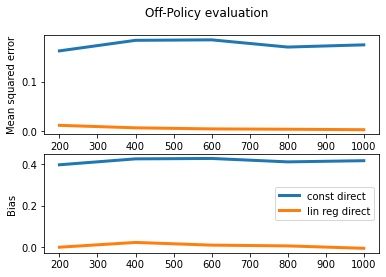

In [3]:
# Direct Estimators

class Estimator:
    def estimate_policy(self, policy, states, actions, rewards):
        pass
    def name(self):
        return self._name

class DirectEstimator(Estimator):
    def estimate(self, state, action):
        pass
    
    def estimate_policy(self, states):
        target_policy = sigmoid(states, theta=-1)
        estimate = target_policy * self.estimate(states, 1)
        estimate += (1 - target_policy) * self.estimate(states, 0)
        return np.mean(estimate) 

## 1. direct estimator with constant reward 

class ConstantDirectEstimator(DirectEstimator):
    def __init__(self, states, actions, rewards):
        self._name = "const direct"
        self._constant_reward = np.zeros(2)
        for action in range(2):
            self._constant_reward[action] = np.sum(rewards[actions==action])/np.sum(actions == action)
 
    def estimate(self, states, action):
        return self._constant_reward[action] * np.ones(len(states))

## 2. direct estimator with lin reg reward

class LinRegDirectEstimator(DirectEstimator):
    def __init__(self, states, actions, rewards):
        self._name = "lin reg direct"
        self._lin_reg_reward = [None] * 2 
        for action in range(2):
            self._lin_reg_reward[action] = LinearRegression().fit(np.expand_dims(states[actions==action],axis=1), rewards[actions == action])
    def estimate(self, states, action):
        return np.squeeze(self._lin_reg_reward[action].predict(np.expand_dims(states,axis=1)))
    
def create_direct_estimators(states, actions, rewards):
    estimators = []

    constant_estimator = ConstantDirectEstimator(states, actions, rewards)
    estimators.append(constant_estimator)

    lin_reg_direct_estimator = LinRegDirectEstimator(states, actions, rewards)
    estimators.append(lin_reg_direct_estimator)    

    return estimators
    
number_of_runs = 20
estimates = np.zeros(shape=(len(sample_sizes), number_of_runs, 2),dtype=float)
for sample_size_idx, sample_size in enumerate(sample_sizes):
#    print(f"sample size {sample_size}")

    for run in range(number_of_runs):

        states = np.random.normal(size = sample_size)
        behavior_policy = sigmoid(states, theta=1)
        actions = np.random.binomial(1, behavior_policy)
        rewards = generate_rewards(states, actions)

        estimators = create_direct_estimators(states, actions, rewards)

        for estimator_idx, estimator in enumerate(estimators):
            estimate = estimator.estimate_policy(states)
#            print(estimator.name(), estimate)
            estimates[sample_size_idx, run, estimator_idx] = estimate
    
def plot_data(estimates):

    mean_error = np.mean(estimates, axis=1) - v0
    mse = np.square(mean_error) + np.square(np.std(estimates, axis=1))
    plt.figure(figsize=(6, 4), dpi=100)
    fig, axs = plt.subplots(2)
    fig.suptitle("Off-Policy evaluation")
    
    # Plotting both the curves simultaneously
    for idx in range(mse.shape[1]):
        axs[0].plot(sample_sizes, mse[:,idx], label=estimators[idx].name(), linewidth=3)
        axs[1].plot(sample_sizes, mean_error[:,idx], label=estimators[idx].name(), linewidth=3)
    
    # Naming the x-axis, y-axis and the whole graph
    axs[0].set_xlabel("Sample Size")
    axs[0].set_ylabel("Mean squared error")
    
    # axs[0].plt.xlabel("Sample Size")
    axs[1].set_ylabel("Bias")
    
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
    
    # To load the display window
    plt.show()

plot_data(estimates)    


As we can see from the above plot, the bias and MSE of linear regression-based direct estimator are very close to zero. To the contrary, the constant model-based direct estimator is biased, due to the misspecification of the reward function

#### Third, we implement the IS estimator. 

The IS estimator is given by
\begin{eqnarray*}
	\frac{1}{T}\sum_{t=0}^{T-1}\frac{\pi(A_t|S_t)}{\widehat{b}(A_t|S_t)}R_t,
\end{eqnarray*}
where $\widehat{b}$ denotes the estimated behavior policy. Using the change of measure theory, we can show that the above estimator is unbiased when $\widehat{b}=b$. 

To estimate the behavior policy, we can similarly consider two models: a constant model under which 
\begin{eqnarray*}
\widehat{b}(a,s)=\frac{1}{T}\sum_{t=0}^{T-1} \mathbb{I}(A_t=a)
\end{eqnarray*}
and a logistic regression model applies a logistic regression with responses $\{R_t:\mathbb{I}(A_t=a)\}_{t\ge 0}$ and predictors $\{S_t:\mathbb{I}(A_t=a)\}_{t\ge 0}$ to estimate $b(a,s)$. Similarly, the constant model will misspecify the reward function whereas the logistic regression model correctly specifies $b$. 

<Figure size 600x400 with 0 Axes>

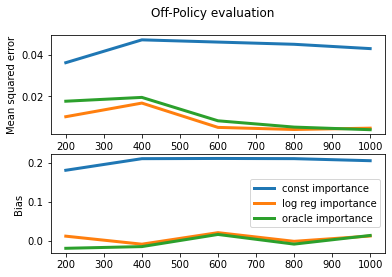

In [4]:
class ImportanceEstimator(Estimator):
    def estimate(self, states):
        pass

    def estimate_policy(self, states, actions, rewards):
        target_policy = sigmoid(states, theta=-1)
        estimate = np.zeros(len(states))
        estimate[actions==1] = target_policy[actions==1] / self.estimate(states[actions==1]) * rewards[actions==1]
        estimate[actions==0] = (1-target_policy[actions==0]) / (1-self.estimate(states[actions==0])) * rewards[actions==0]
        return np.mean(estimate)

## 3. importance sampling estimator with constant policy     
    
class ConstantImportanceEstimator(ImportanceEstimator):
    def __init__(self, states, actions):
        self._name = "const importance"
        self._constant_policy = np.mean(actions) 
    def estimate(self, states):
        return self._constant_policy * np.ones(len(states))

## 4. importance sampling estimator with log regression policy

class LogisticRegressionImportanceEstimator(ImportanceEstimator):
    def __init__(self, states, actions):
        self._name = "log reg importance"
        self._logistic_reg_policy = LogisticRegression().fit(np.expand_dims(states,axis=1), actions)
    def estimate(self, states):
        pred = self._logistic_reg_policy.predict_proba(np.expand_dims(states, axis=1))
        pred = np.squeeze(pred)
        return pred[:,1]
    
## 5. importance sampling estimator with known behavior policy

class OracleImportanceEstimator(ImportanceEstimator):
    def __init__(self, states, actions):
        self._name = "oracle importance"
    def estimate(self, states):
        return sigmoid(states, theta=1)    
    
def create_IS_estimators(states, actions, rewards):
    estimators = []

    constant_importance_estimator = ConstantImportanceEstimator(states, actions)
    estimators.append(constant_importance_estimator)

    logistic_reg_importance_estimator = LogisticRegressionImportanceEstimator(states, actions)
    estimators.append(logistic_reg_importance_estimator)

    oracle_importance_estimator = OracleImportanceEstimator(states, actions)
    estimators.append(oracle_importance_estimator)

    return estimators

number_of_runs = 20
estimates = np.zeros(shape=(len(sample_sizes), number_of_runs, 3),dtype=float)
for sample_size_idx, sample_size in enumerate(sample_sizes):
#    print(f"sample size {sample_size}")

    for run in range(number_of_runs):

        states = np.random.normal(size = sample_size)
        behavior_policy = sigmoid(states, theta=1)
        actions = np.random.binomial(1, behavior_policy)
        rewards = generate_rewards(states, actions)

        estimators = create_IS_estimators(states, actions, rewards)

        for estimator_idx, estimator in enumerate(estimators):
            estimate = estimator.estimate_policy(states, actions, rewards)
#            print(estimator.name(), estimate)
            estimates[sample_size_idx, run, estimator_idx] = estimate
            
plot_data(estimates) 

As we can see from the above plot, biases and MSEs of logistic regression-based IS and oracle IS estimators are very close to zero. To the contrary, the constant model-based IS estimator is biased, due to the misspecification of the behavior policy. In addition, comparing the logistic regression-based IS and the oracle IS estimator, it is easy to tell that the former has a smaller variance. This aligns with the following fact we discussed in the lecture

<img src="graphs/fact3.png" width=800>

#### Finally, we implement the doubly-robust estimator. 

The doubly-robust estimator is given by
\begin{eqnarray*}
	\frac{1}{T}\sum_{t=0}^{T-1} \sum_a \pi(a|S_t)\widehat{r}(S_t,a)+\frac{1}{T}\sum_{t=0}^{T-1}\frac{\pi(A_t|S_t)}{\widehat{b}(A_t|S_t)}[R_t-\widehat{r}(S_t,A_t)].
\end{eqnarray*}
The first term in the above equation is the direct estimator whereas
 the second term corresponds to an augmentation term. The purpose of adding the augmentation term is to offer additional protection against potential model misspecification of the reward function. It can be shown that the above estimator is doubly-robust, in the sense that it is consistent when either $\widehat{r}$ or $\widehat{b}$ is correctly specified. 

We similarly consider two choices of reward functions and two choices of behavior policies. This yields a total of 4 doubly-robust estimators.

<Figure size 600x400 with 0 Axes>

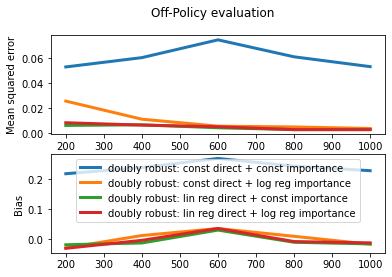

In [5]:
class DoublyRobustEstimator(Estimator):
    def __init__(self, direct_estimator, importance_estimator):
        self._name = "doubly robust: " + direct_estimator.name() + " + " + importance_estimator.name()
        self._direct_estimator = direct_estimator
        self._importance_estimator = importance_estimator
    def estimate_policy(self, states, actions, rewards):
        rb = np.zeros(len(states))
        rb[actions==1] = self._direct_estimator.estimate(states[actions==1], 1)
        rb[actions==0] = self._direct_estimator.estimate(states[actions==0], 0)
        estimate = np.zeros(len(states))
        target_policy = sigmoid(states, theta=-1)
        estimate[actions==1] = target_policy[actions==1] / self._importance_estimator.estimate(states[actions==1]) * rb[actions==1]
        estimate[actions==0] = (1-target_policy[actions==0]) / (1-self._importance_estimator.estimate(states[actions==0])) * rb[actions==0]
        return self._direct_estimator.estimate_policy(states) + self._importance_estimator.estimate_policy(states,actions, rewards) - np.mean(estimate)
    
def create_DR_estimators(states, actions, rewards):
    estimators = []

    constant_estimator = ConstantDirectEstimator(states, actions, rewards)

    lin_reg_direct_estimator = LinRegDirectEstimator(states, actions, rewards)
    
    direct_estimators = [constant_estimator, lin_reg_direct_estimator]

    constant_importance_estimator = ConstantImportanceEstimator(states, actions)

    logistic_reg_importance_estimator = LogisticRegressionImportanceEstimator(states, actions)
    
    importance_estimators = [constant_importance_estimator, logistic_reg_importance_estimator]

    doubly_robust_estimators = []
    for dir_est in direct_estimators:
        for imp_est in importance_estimators:
            estimators.append(DoublyRobustEstimator(dir_est,imp_est))

    return estimators

number_of_runs = 20
estimates = np.zeros(shape=(len(sample_sizes), number_of_runs, 4),dtype=float)
for sample_size_idx, sample_size in enumerate(sample_sizes):
#    print(f"sample size {sample_size}")

    for run in range(number_of_runs):

        states = np.random.normal(size = sample_size)
        behavior_policy = sigmoid(states, theta=1)
        actions = np.random.binomial(1, behavior_policy)
        rewards = generate_rewards(states, actions)

        estimators = create_DR_estimators(states, actions, rewards)

        for estimator_idx, estimator in enumerate(estimators):
            estimate = estimator.estimate_policy(states, actions, rewards)
#            print(estimator.name(), estimate)
            estimates[sample_size_idx, run, estimator_idx] = estimate
            
plot_data(estimates) 

We make a few observations. First, it can be seen that only one DR estimator that uses the constant model to parameterize both the behavior policy and the reward function is not consistent. All other three models are consistent. This verifies the doubly-robustness property, as we discussed in the lecture. 

<img src="graphs/fact1.png" width=800>

Second, it can be seen that among the three consistent DR estimators, the one that misspecifies the reward function (uses a constant model for the reward) has a larger MSE. This verifies Fact 2 that we covered in the lecture

<img src="graphs/fact2.png" width=800>